# Marching cubes

[Marching cubes](https://de.wikipedia.org/wiki/Marching_Cubes) was developed in 1987 and was originally designed for [efficient visualization of medical image data](https://dl.acm.org/doi/10.1145/37402.37422). In short, a cube-shaped neighborhood is moved through the image and the and the corners of the cube are classified as either inside or outside the object of interest. The cube is then triangulated based on the classification of the corners. This is repeated for all cubes in the image. The result is a triangulated surface that approximates the object of interest.

![](./img_13.png)

Among other algorithms, marching cubes presents a key method to transition from volumetric data to surface space. It is implemented, for instance, in [scikit-image](https://scikit-image.org/docs/stable/auto_examples/edges/plot_marching_cubes.html).

## Dependencies

Before running this notebook, make sure to install the following dependencies:

```bash
mamba install vedo napari-process-points-and-surfaces
```

In [1]:
import napari_process_points_and_surfaces as nppas
import napari_segment_blobs_and_things_with_membranes as nsbatwm
from skimage import measure, data

import vedo
import napari

In [2]:
vedo.settings.default_backend= 'vtk'

In [3]:
viewer = napari.Viewer(ndisplay=3)

## Segmentation

We first obtain a segmentation of some data to get started. We continue where we left of in one of the previous notebooks about [voronoi-otsu thresholding](./11_voronoi_otsu_labeling.ipynb).

In [4]:
raw_data = data.cells3d()

In [5]:
outline_sigma = 2
nuclei_sigma = 10

In [6]:
nuclei = raw_data[:, 1]
segmentation = nsbatwm.voronoi_otsu_labeling(nuclei, spot_sigma=nuclei_sigma, outline_sigma=outline_sigma)

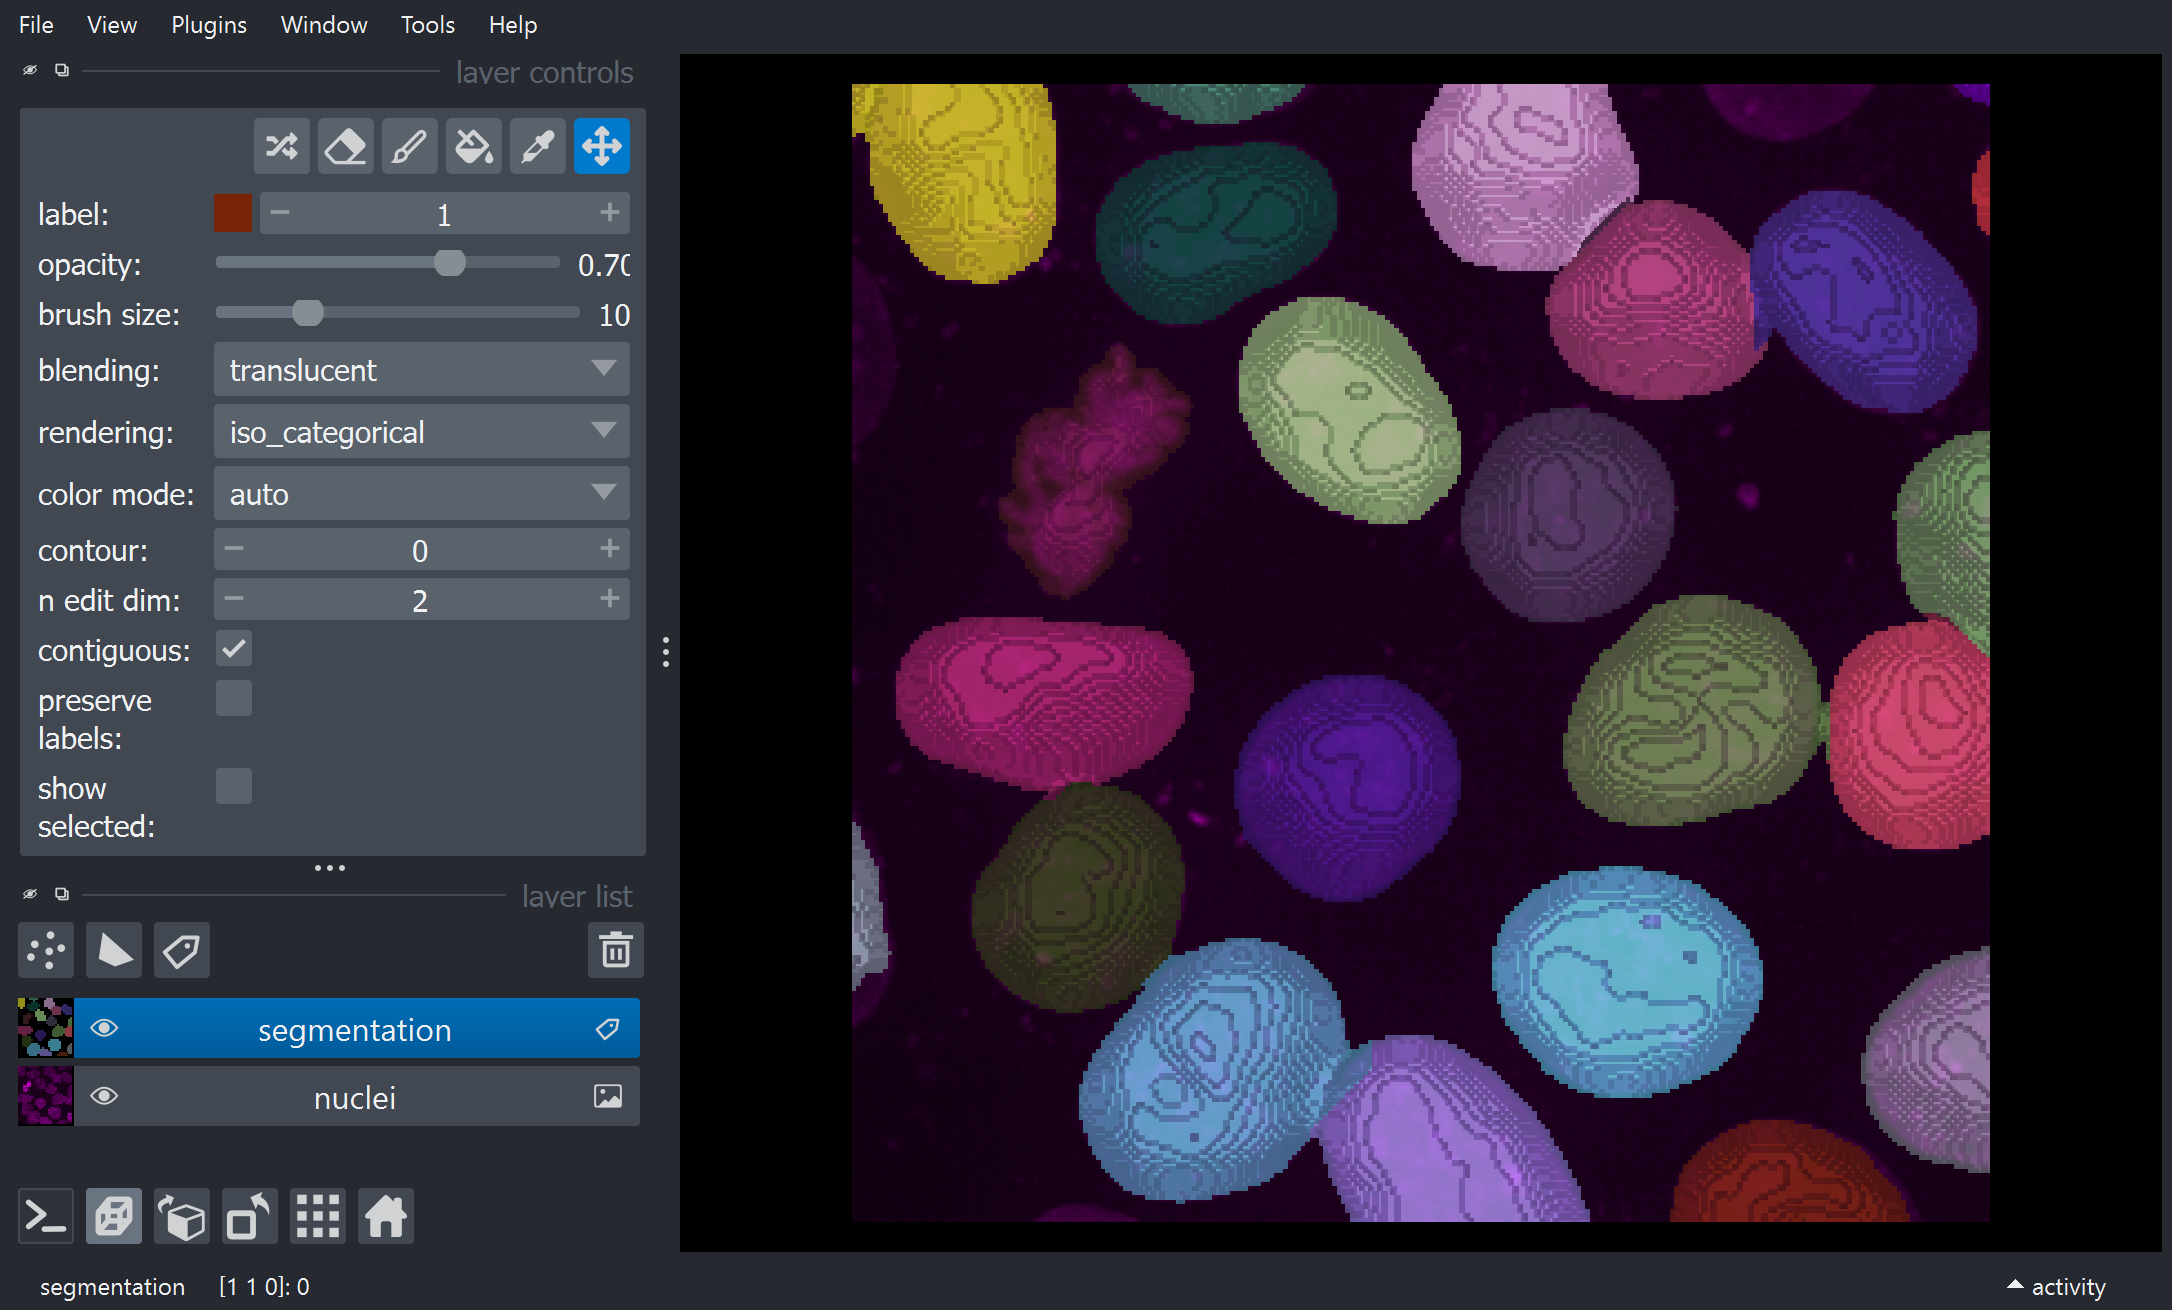

In [7]:
viewer.add_image(nuclei, name='nuclei', colormap='magenta', blending='additive')
viewer.add_labels(segmentation)
napari.utils.nbscreenshot(viewer)

## Surface extraction

Next up, we use the marching cubes algorithm to extract a surface from the segmented data. It separately returns the vertices, faces, normal vectors and values of the extracted isosurface. The normals, in particular, are useful for shading the surface and creating a smooth rendering: If the normal vectors of a surface are known, the reflection angles of incendent light can be computed.

In [8]:
# this creates a mesh from a single object
vertices, faces, normals, values = measure.marching_cubes(segmentation==14)

Alternative implementations can be found, for instance, in napari-process-points-and-surfaces:

In [18]:
surface = nppas.label_to_surface(segmentation, label_id=14)
largest_surface = nppas.largest_label_to_surface(segmentation)

When working with surfaces in napari, we typically express a surface as a `Tuple` of two `ndarrays`: the first array contains the coordinates of the vertices of the surface, and the second array contains the indices of the vertices that make up the edges of the surface.

For example, a simple square surface could be expressed as:

```python
vertices = np.array([[0, 0], [0, 1], [1, 1], [1, 0]])
edges = np.array([[0, 1], [1, 2], [2, 3], [3, 0]])
surface = (vertices, edges)
```

In [9]:
surface = (vertices, faces)
surface_layer = viewer.add_surface(surface)
surface_layer.wireframe.visible = True

If we zoom in closely, we can see that the surface actually consists of triangles.

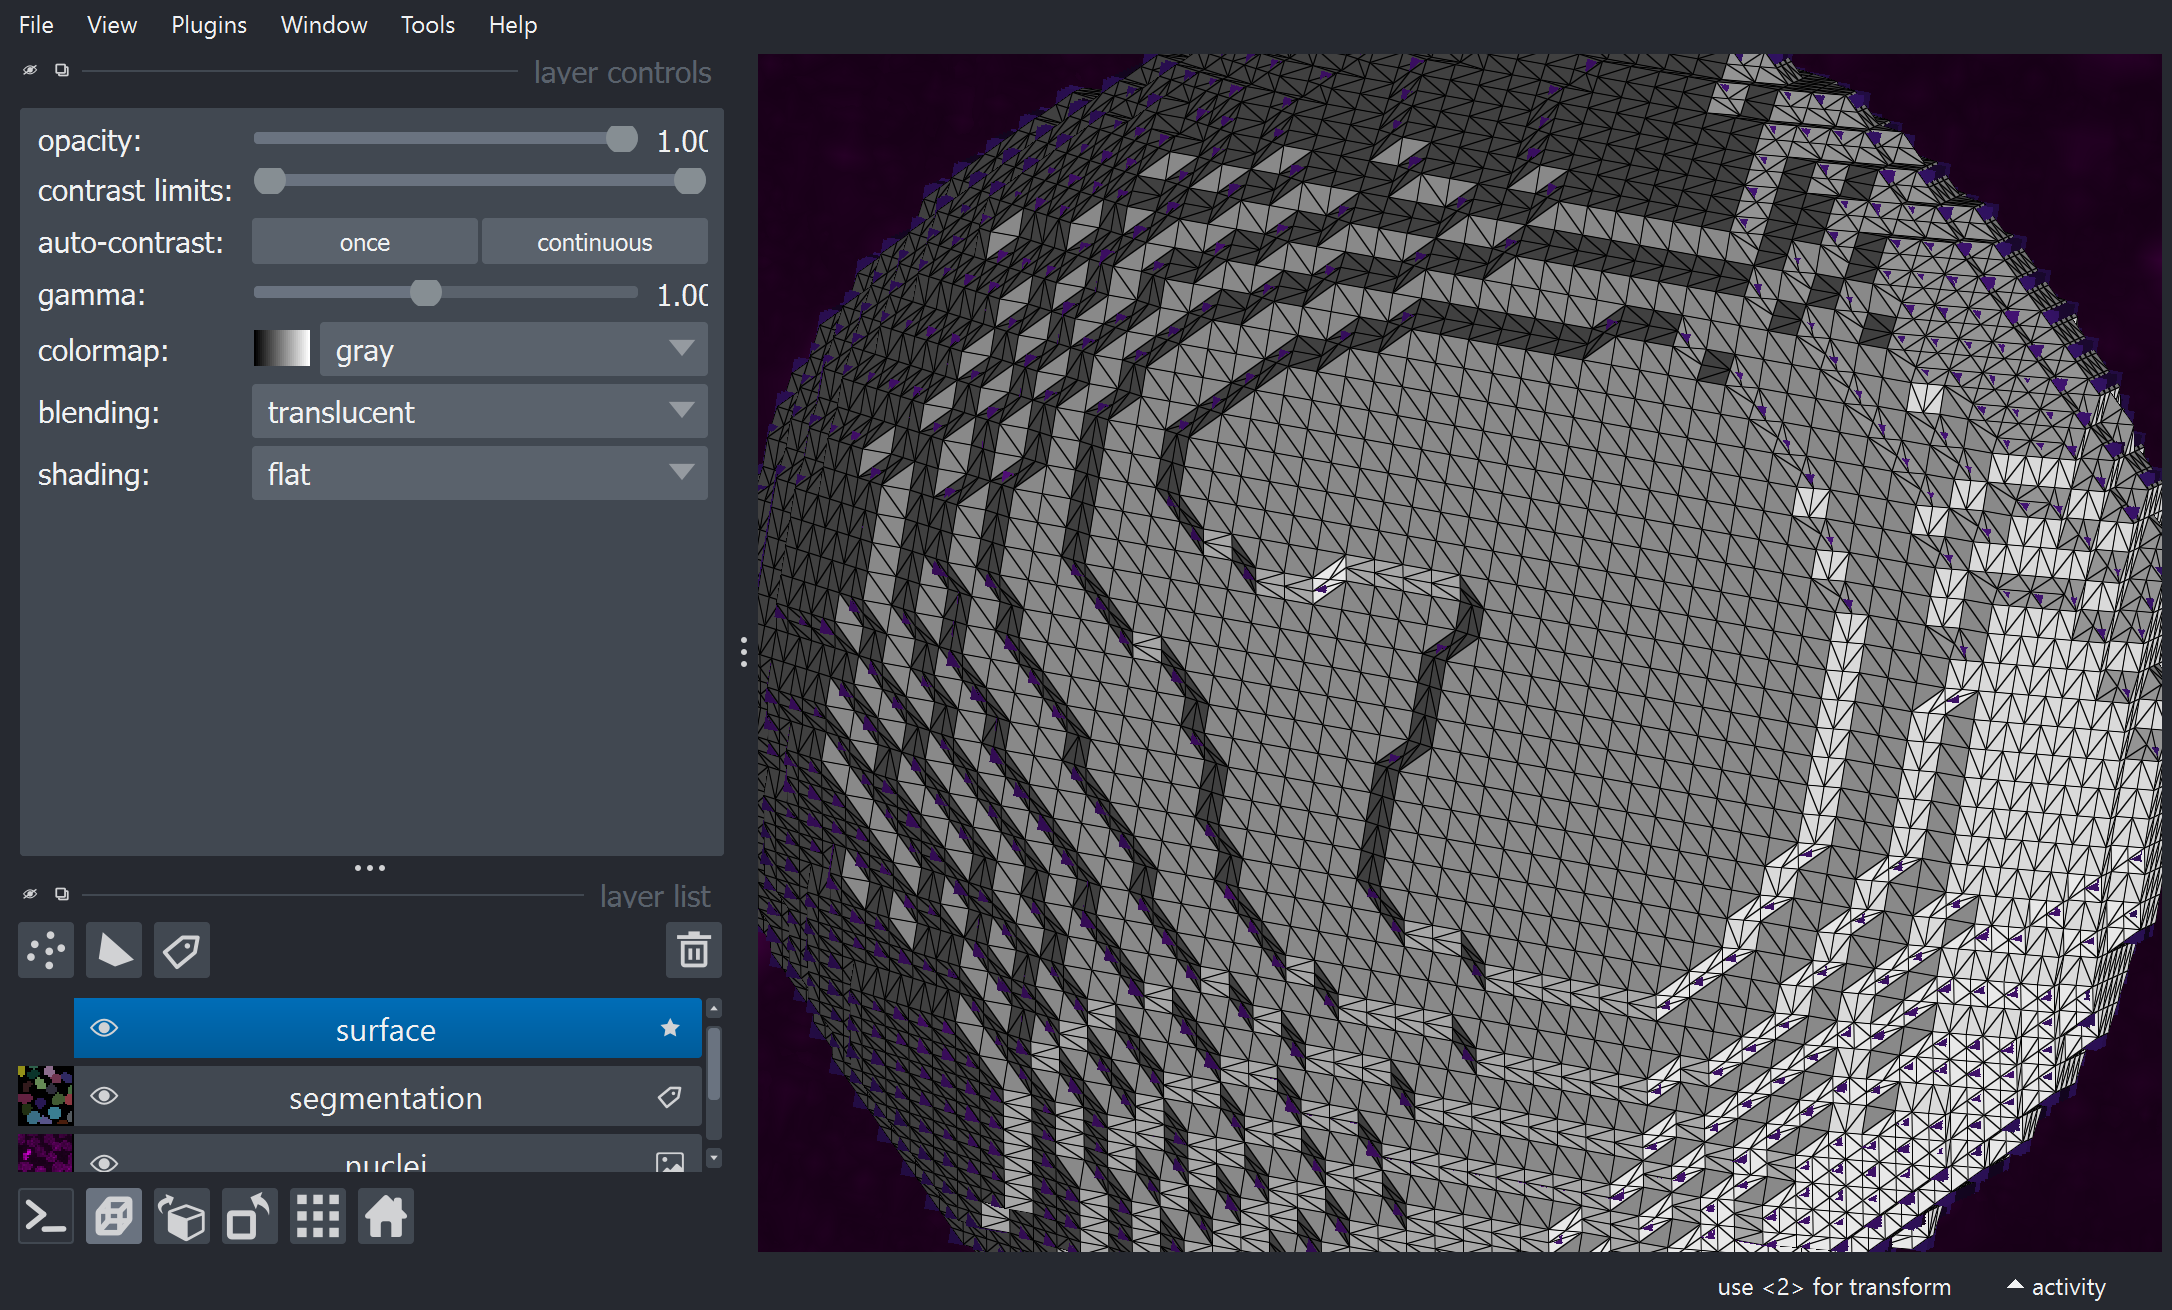

In [10]:
napari.utils.nbscreenshot(viewer)

## Working with vedo

This is a good time to introduce the [vedo](https://vedo.embl.es) Mesh class. It allows to encapsulate a lot of the functionality we have seen so far in a single object. It also allows to easily save and load meshes from disk. For once, vedo provides a simple rendering inside the notebook:

(Mesh)0000021156241160
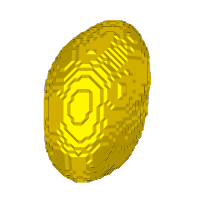

In [11]:
vedo_mesh = vedo.Mesh(surface)
vedo_mesh

However, vedo also provides its own viewer:

In [14]:
plt = vedo.Plotter()
plt += vedo_mesh
plt.show(axes=1, viewup='z', zoom=1.5)

## Exercise 1:

Add the above-extracted surface of the largest label to both the napari and the vedo viewer.

Exercise 2:

Use vedo to save any of the above-created meshes as an `.obj` file.